# Исследование данных сервиса аренды самокатов GoFast

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.


### Краткое описание проекта

Основные данные проекта состоят из трех датафреймов - в них данные о пользователях, их поездках и типах подписок. Эти датафреймы в рамках работы нужно будет обработать - избавиться от пропусков и дубликатов, а также проверить, есть ли какие-либо аномальные значения.

Основная цель проекта - проверить гипотезы, которые возникли у продакт-менеджеров. На достоверность или ложность этих гипотез команда будет опираться при проведении акций для увеличения числа пользователей с подпиской. Эти гипотезы мы будем проверять с помощью методов библиотеки scipy. 

****План работы будет следующим:****

1. Изучение и предобработка данных
Посмотрим на содержание датафреймов, изучим, какие типы данных и их объем они содержат. На этом этапе изучим, какие типы данных лучше изменить, и проведем предобработку - приведем данные к нужному типу, избавимся от дубликатов и пропусков (при наличии).


2. Исследовательский анализ данных
Визуализируем содержимое датафреймов с помощью гистограмм и других способов отображения данных. Это позволит лучше понять, есть ли аномальные значения, и выдвинуть гипотезы, чем их можно объяснить. Кроме того, на этом этапе изучим важные параметры - частоту встречаемости городов, возраст пользователей, продолжительность поездок по времени и расстоянию.


3. Объединение данных и подсчет выручки
Создадим общий датафрейм, которые будет содержать данные из трех датафреймов. Затем на его основе создадим отдельные наборы данных о пользователях с платной и бесплатной подписками. Добавим столбец с месячной выручкой по каждому пользователю в общий датафрейм.


4. Проверка гипотез
С помощью методов статистического анализа попробуем опровергнуть или подтвердить выдвинутые продакт-менеджерами гипотезы. Обрабатоем результаты анализа и добавим выводы, которые позволят бизнесу повысить эффективность акций для привлечения пользователей.


5. Общие выводы
Соберем все выводы, которые получится получить в рамках проекта, для удобства в одном блоке. 

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import pylab
import seaborn as sns
from termcolor import colored

#### Шаг 1. Загрузка данных

In [2]:
try:
    users = pd.read_csv('/datasets/users_go.csv')
    rides = pd.read_csv('/datasets/rides_go.csv')
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except FileNotFoundError:
    users = pd.read_csv('/Users/macbookpro/Downloads/users_go.csv')
    rides = pd.read_csv('/Users/macbookpro/Downloads/rides_go.csv')
    subscriptions = pd.read_csv('/Users/macbookpro/Downloads/subscriptions_go.csv')

display(rides.head())
display(users.head())
display(subscriptions.head())

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [3]:
print(colored('Информация о датафрейме с поездками:', 'red', attrs=['bold']))
rides.info()
print()
print(colored('Информация о датафрейме с пользователями:', 'red', attrs=['bold']))
users.info()
print()
print(colored('Информация о датафрейме с типами подписок:', 'red', attrs=['bold']))
subscriptions.info()

Информация о датафрейме с поездками:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB

Информация о датафрейме с пользователями:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB

Информация о датафрейме с т

#### Предварительные выводы, которые можно сделать по нашим датафреймам:

1. Самый большой по количеству строк - датафрейм с информацией о поездках. Скорее всего, один и тот же пользователь совершал несколько поездок, так как в датафрейме с информацией о них всего 1565 строк. При этом в датафрейме о поездках 18 тысяч строк.

2. Так как наш план - объединить три датафрейма в один с помощью параметра merge(), на этой стадии посмотрим, по какому столбцу это можно сделать. Мы видим, что в первых двух датафреймах есть столбец с категориальными переменными user_id. Но в датафрейме с информацией о подписках его нет: из него вытащим информацию для категорий пользователей с подписками и без.

3. Сразу можно наметить задачи для предобработки: date в датафрейме rides приведем к формату datetime64. Кроме того, проверим пропущенные значения и дубликаты.

#### Шаг 2. Предобработка данных

Сперва проверим, есть ли в датафреймах пропущенные значения. В датафрейме subscriptions искать их не будем: он состоит из двух строк.

In [4]:
print(rides.isnull().sum())
print(users.isnull().sum())

user_id     0
distance    0
duration    0
date        0
dtype: int64
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


Как мы видим, пропущенные значения отсутствуют. А что насчет явных дубликатов? 

In [5]:
print(f'Количество явных дубликатов в датафрейме с поездками: {rides.duplicated().sum()}')
print(f'Количество явных дубликатов в датафрейме с пользователями: {users.duplicated().sum()}')

Количество явных дубликатов в датафрейме с поездками: 0
Количество явных дубликатов в датафрейме с пользователями: 31


Видим, что явные дубликаты есть в датафрейме с пользователями, вот они: 

In [6]:
users[users.duplicated()]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


Отбросим эти значения и проверим датафрейм на дубликаты: 

In [7]:
users = users.drop_duplicates(subset=['user_id'], keep='first')
users.duplicated().sum()

0

Перейдем к обработке типов данных и созданию нужных столбцов:

In [8]:
#date в датафрейме rides приведем к формату datetime64
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

#создадим в rides новый столбец с номером месяца
rides['month'] = rides['date'].dt.month

rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [9]:
rides['date'].dt.year.unique()

array([2021])

Мы видим, что данные внутри датафрейма относятся к одному году - это 2021 год. Значит, при присвоении нумерации месяцев не должно быть ошибок, так как месяцам будут присваиваться номера в рамках одного года.

#### Предварительные выводы после предобработки данных:

1. Мы привели тип данных в столбце date к формате datetime64 и создали столбец с номером месяца в поездке.

2. В датафрейме с пользователями обнаружили 31 явный дубликат. Отбросили их, оставив первые значения.

3. В остальном в датафрейме нет пропусков или неясных дубликатов. Можно дальше работать с данными.

#### Шаг 3. Исследовательский анализ данных

#### Задачи 3.1-3.3. Визуализация данных из датафрейма о пользователях: частота городов, соотношение по типу подписки и возрасту

Чтобы не создавать отдельную гистограмму по каждому из исследуемых параметров, вынесем нужные столбцы в отдельный датафрейм и создадим функцию, которая будет визуализировать каждый из нужных нам столбцов. В ней будем использовать subplots и метод histplot() из библиотеки seaborn.

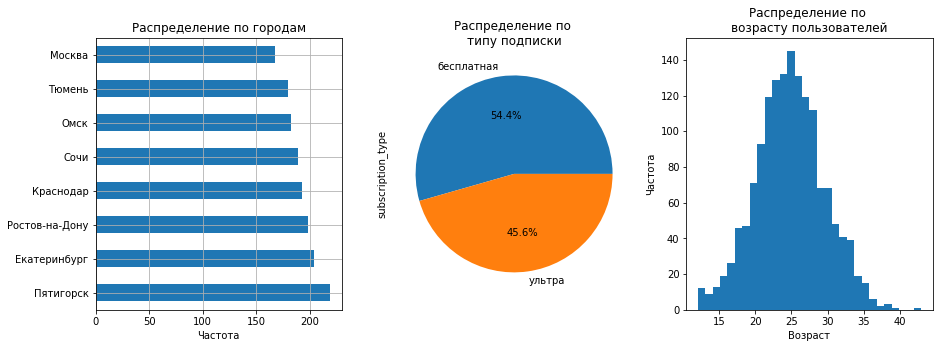

In [10]:
#cоздадим переменные, которые будем использовать в качестве x и y для визуализаций
city_count = users['city'].value_counts()
subscription_count = users['subscription_type'].value_counts()
labels = ['бесплатная', 'ультра']

#создадим subplot, чтобы отобразить три графика в одной строке
_, ax = plt.subplots(1, 3, figsize=(15, 5))

#создадим горизонтальный барплот для распределения по городам, используя созданную выше переменную
users['city'].value_counts().plot(y=city_count, ax=ax[0], grid=True, kind='barh')

#создадим круговую диаграмму с указанием процентного соотношения
#переменную labels используем для русскоязычного подписания
users['subscription_type'].value_counts().plot(y= subscription_count, ax=ax[1], kind = 'pie', 
                                               autopct='%1.1f%%', labels=labels)
plt.hist(users['age'], bins = 30)

#добавим к визуализациям необходимые подписи
ax[0].set_title('Распределение по городам')
ax[0].set_xlabel('Частота')
ax[1].set_title('Распределение по \nтипу подписки')
ax[2].set_title('Распределение по \nвозрасту пользователей')
ax[2].set_xlabel('Возраст')
ax[2].set_ylabel('Частота')

plt.show()

****Выводы по визуализации датафрейма с пользователями:****

1. Количество пользователей из разных городов внутри датафрейма несильно отличается: минимальное значение соответствует примерно 175, максимальное - 225. Больше всего пользователей из Пятигорска, Екатеринбурга и Ростова-на-Дону, меньше всего - из Москвы.

2. Пользователей, у которых нет подписки, больше, чем пользователей с подпиской: 830 против 700.

3. Больше всего данных о пользователях в возрасте от 20 до 28 лет. Чаще всего попадаются данные о пользователях в возрасте 25 лет (примерно 150), реже - данные о пользователях в возрасте 40 лет (значение близко к нулю). Количество пользователей в датафрейме начинает снижаться с категорией старше 35 лет. Это соответствует правде: такие пользователи вряд ли относятся к ЦА.

#### Задачи 3.4-3.5. Визуализация данных из датафрейма о поездках: расстояние за одну поездку и продолжительность

Аналогично поступим с данными из датафрейма про поездки, но на этот раз оставим значения из столбцов в оси x: графика два, они поместятся горизонтально. Чуть увеличим число корзин, чтобы посмотреть на аномалии и пики внутри данных.

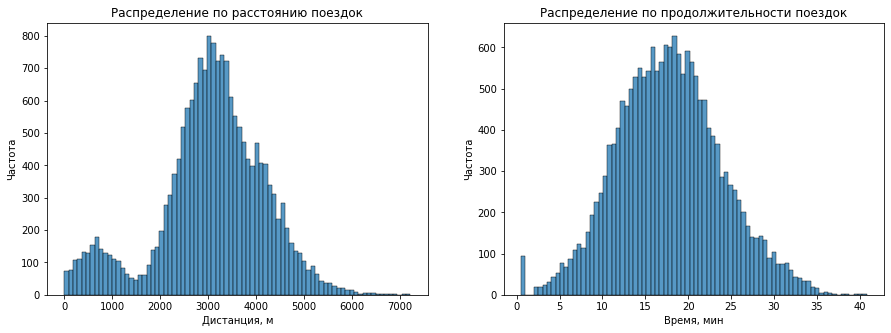

In [11]:
rides_visual = rides[['distance', 'duration']]

fig, ax = plt.subplots(1, 2,  figsize=(15, 5))

for num, col in enumerate(rides_visual):
    sns.histplot(
        data = rides_visual, 
        x = col, 
        ax = ax[num],
        bins = 80
    )    
    ax[0].set_title('Распределение по расстоянию поездок')
    ax[1].set_title('Распределение по продолжительности поездок')
    ax[0].set_xlabel('Дистанция, м')
    ax[0].set_ylabel('Частота')
    ax[1].set_xlabel('Время, мин')
    ax[1].set_ylabel('Частота')

In [12]:
describe1 = rides.distance.describe()
describe2 = rides.duration.describe()

print(colored('Информация о  дистанции поездок:', 'red', attrs=['bold']))
print(describe1)
print()
print(colored('Информация о продолжительности поездок:', 'red', attrs=['bold']))
print(describe2)

Информация о  дистанции поездок:
count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Информация о продолжительности поездок:
count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64


****Расстояние поездок****

1. Гистограмма распределена близко к нормальному значению, но есть небольшой пик между 0 и 1000 м. Пока не будем считать эти данные как аномалию: логично предположить, что часть пользователей использует самокаты как способ передвижения на небольшие расстояния.

2. Данные с расстоянием, близким к нулю (0-100 м) могут приходиться на пользователей, которые столкнулись с ошибкой или ПО, или аппаратной (разряженный самокат): из-за нее им пришлось завершить поездку.

3. Основное пиковое значение приходится на расстояние примерно в 3070 м.

4. После 5500 м данных почти нет: пользователи попросту не ездят на самокатах на такие дальние расстояния. 

****Продолжительность поездок****

1.  Гистограмма распределена близко к нормальному значению, но есть небольшой пик между 0 и 2 минутами. Пока не будем считать эти данные как аномалию.

2. Данные, близкие к 0 минут, можно объяснить так: вероятно, пользователи, которые проездили на самокате меньше 2 минут, столкнулись с ошибкой ПО или аппаратной ошибкой.

3.  Основное пиковое значение приходится на продолжительность поездки примерно в 17.8 минут.

4. После 35 минут данных почти нет. Это соответствует ожиданию: пользователи вряд ли часто используют самокаты для долгих заездов.

In [13]:
possible_anomaly = rides.query('duration <= 1')
print(possible_anomaly)
print()
print(colored('Информация о возможных аномальных поездках:', 'red', attrs=['bold']))
possible_anomaly.describe()

       user_id     distance  duration       date  month
6531       701  4196.445201       0.5 2021-08-31      8
6570       704  4830.824371       0.5 2021-10-14     10
6680       712  4684.004397       0.5 2021-03-04      3
6695       713  5215.642710       0.5 2021-02-25      2
6768       718  5197.436649       0.5 2021-02-11      2
...        ...          ...       ...        ...    ...
17004     1460  5531.335845       0.5 2021-01-19      1
17242     1477  6724.932981       0.5 2021-01-12      1
17314     1483  4445.481070       0.5 2021-03-06      3
17505     1496  5722.551787       0.5 2021-02-14      2
17909     1524  4103.998874       0.5 2021-06-18      6

[95 rows x 5 columns]

Информация о возможных аномальных поездках:


,user_id,distance,duration,month
count,95.000000,95.000000,95.0,95.000000
mean,1092.210526,5113.176549,0.5,6.484211
std,244.028551,658.254104,0.0,3.709858
min,701.000000,4030.308008,0.5,1.000000
25%,901.000000,4611.510820,0.5,3.000000
50%,1069.000000,5052.769411,0.5,6.000000
75%,1310.500000,5488.459099,0.5,10.000000
max,1524.000000,7211.007745,0.5,12.000000


Мы видим, что 95 строчек о поездках содержат записи о поездках продолжительностью в среднем в 30 секунд и средним расстоянием в 5113 метров. Скорее всего, эти записи содержат ошибку – за такое время невозможно проехать больше 5 км на самокате. Ошибка, вероятно, могла быть вызвана человеческим фактором: например, записью в часах вместо минут.

На следующем этапе будем использовать датафрейм без этих строк - создадим очищенный с помощью метода query().

In [14]:
clear_rides = rides.query('duration >= 1')
clear_rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


#### Предварительные выводы после исследовательского анализа данных:

1. Количество пользователей из разных городов внутри датафрейма несильно отличается. Больше всего пользователей из Пятигорска, Екатеринбурга и Ростова-на-Дону, меньше всего - из Москвы.

2. Пользователей, у которых нет подписки, немного больше, чем пользователей с подпиской.

3. Анализ гистограмм натолкнул на гипотезу: часть пользователей использует самокаты как способ передвижения на небольшие расстояния.

4. Основное пиковое значение по расстоянию поездок приходится на примерно 3000 м, по продолжительности поездок - около 18 минут.

5. На этом этапе мы выявили еще 95 строк с аномальными данными по поездкам пользователей. Удалять их не будем, так как не знаем их природу, но на следующем этапе будем использовать датафрейм без этих строк.

#### Шаг 4. Объединение данных

#### Задача 4.1. Объединение данные о пользователях, поездках и подписках

Разделим объединение на два этапа для удобства:

1. Сперва объединим датафреймы о пользователях и поездках по столбцу 'user_id' в датафрейм data
2. Затем объединим датафрейм data с данными о подписках по столбцу 'subcription_type'

In [15]:
data = users.merge(clear_rides, how='inner', on='user_id')
data = data.merge(subscriptions, how='inner', on='subscription_type')
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


В результате мы получили один датафрейм, который содержит данные о пользователях, поездках и подписках.

In [16]:
print(f'Количество строк в объединенном датафрейме:{len(data)}')
print()
print(f'Количество строк в очищенном датафрейме по поездкам:{len(clear_rides)}')

Количество строк в объединенном датафрейме:17973

Количество строк в очищенном датафрейме по поездкам:17973


#### Задача 4.2. Создайте ещё два датафрейма на основе одного существующего

На основе нашего объединенного датафрейма создадим еще два - с информацией о пользователях с оформленной и бесплатной подписками. Для этого воспользуемся методом query().

In [17]:
subscription_ultra = data.query("subscription_type == 'ultra'")
display(subscription_ultra.head())

subscription_free = data.query("subscription_type == 'free'")
display(subscription_free.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


Мы видим, что с помощью .query() удалось быстро выделить два датафрейма с наборами данных.

#### Задача 4.3 Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий

Отобразим по два графика для каждого датафрейма и наложим их друг на друга.

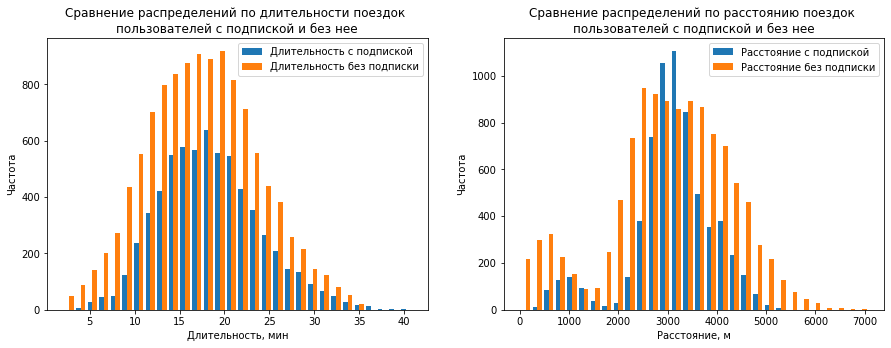

In [18]:
fig, ax_arr = plt.subplots(1, 2,  figsize=(15, 5))

ultra_duration = subscription_ultra.duration
free_duration = subscription_free.duration
ultra_distance = subscription_ultra.distance
free_distance = subscription_free.distance

ax_arr[0].hist([ultra_duration, free_duration], 
         bins=30, 
         label=['Длительность с подпиской', 
                'Длительность без подписки'])

ax_arr[1].hist([ultra_distance, free_distance], 
        bins=30, label=['Расстояние с подпиской', 
                        'Расстояние без подписки'])

ax_arr[0].legend(loc='best')
ax_arr[0].set_xlabel('Длительность, мин')
ax_arr[0].set_ylabel('Частота')
ax_arr[0].set_title('Сравнение распределений по длительности поездок \nпользователей с подпиской и без нее')

ax_arr[1].legend(loc='best')
ax_arr[1].set_xlabel('Расстояние, м')
ax_arr[1].set_ylabel('Частота')
ax_arr[1].set_title('Сравнение распределений по расстоянию поездок \nпользователей с подпиской и без нее')


plt.show()

#### Предварительные выводы после визуализации:

1. Мы видим, что у пользователей с бесплатной подпиской в левых хвостах от пика гистограмм более ярко выражены аномалии. Это близко к правде: пользователи без платной подписки могут реже пользоваться сервисом и чаще сталкиваться с ошибками в ПО или аппаратными. 

2. Есть и другая гипотеза - пользователей без платной подписки может отпугивать сам факт оплаты за минуты и за старт. Поэтому они попросту отказываются от поездок.

3. При этом поведение пользователей с платной и бесплатной подпиской сильно в целом не отличается. Пики по расстоянию приходятся примерно на 3100 м, пики по продолжительности поездок - примерно на 17-18 минут.  

#### Шаг 5. Подсчёт выручки

#### Задача 5.1. Найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [25]:
#приведем продолжительность каждой поездки в исходном датафрейме к целому значению
data['duration'] = np.ceil(data['duration'])
user_info = ( 
    data.pivot_table(index = ['month', 'user_id'], values = ['distance', 'date', 'duration', 'subscription_type'], 
                              aggfunc = {'distance': 'sum', 'date': 'count',  'duration':'sum', 'subscription_type':'min'})
    .reset_index()
)
user_info.columns = ['month', 'user_id', 'total_rides', 'total_distance', 'total_duration', 'subscription_type']
user_info.head()

,month,user_id,total_rides,total_distance,total_duration,subscription_type
0,1,1,2,7027.511294,42.0,ultra
1,1,3,1,3061.777147,13.0,ultra
2,1,5,1,3914.646990,13.0,ultra
3,1,7,2,6478.080979,28.0,ultra
4,1,12,1,3577.151148,33.0,ultra


#### Задача 5.2. Добавьте столбец с помесячной выручкой, которую принёс каждый пользователь

In [26]:
#добавим в наш датафрейм данные о подписках, чтобы корректно посчитать выручку

user_info = user_info.merge(subscriptions, how='inner', on='subscription_type')

#посчитаем стоимость поездки для каждого пользователя

user_info['monthly_revenue'] = (user_info['total_duration'] * user_info['minute_price']) + (user_info['start_ride_price'] * user_info['total_rides']) + user_info['subscription_fee']
#переведем данные из столбца из Series в int64
user_info['monthly_revenue'] = user_info['monthly_revenue'].astype('int')
user_info.head()

,month,user_id,total_rides,total_distance,total_duration,subscription_type,minute_price,start_ride_price,subscription_fee,monthly_revenue
0,1,1,2,7027.511294,42.0,ultra,6,0,199,451
1,1,3,1,3061.777147,13.0,ultra,6,0,199,277
2,1,5,1,3914.646990,13.0,ultra,6,0,199,277
3,1,7,2,6478.080979,28.0,ultra,6,0,199,367
4,1,12,1,3577.151148,33.0,ultra,6,0,199,397


#### Предварительные выводы после подсчета выручки:

1. По итогам этого этапа мы добавили новый общий датафрейм user_info с агрегированными данными. В нем нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

2. В этот датафрейм мы добавили столбец с помесячной выручкой, которую принес каждый пользователь.


#### Шаг 6. Проверка гипотез

#### Задача 6.1. Важно понять, тратят ли пользователи с подпиской больше времени на поездки?

Cперва сформулируем нулевую и одностороннюю альтернативную гипотезы:
    
****H0 = Среднее время поездок у всех пользователей с подпиской равно среднему времени поездок всех пользователей без подписки.****

****H1 = Среднее время поездок у всех пользователей с подпиской больше среднего времени поездок всех пользователей без подписки.****

#### Проверка гипотезы 6.1

Чтобы проверить гипотезу, воспользуемся методом проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. T-тест будем применять, так как все три параметра соблюдены:

1. В нашем случае выборочные средние распределены близко к нормальному вокруг истинного среднего этой совокупности, так как размер каждой выборки больше нескольких десятков значений.
2. Генеральные совокупности не зависят друг от друга: в выборках у нас данные о разных пользователях, они не пересекаются.
3. Даже если дисперсии генеральных совокупностей не равн, согласно симуляциям, проведенным учеными, тест вряд ли ошибется.

In [21]:
free_rides_duration = subscription_free.duration 

ultra_rides_duration = subscription_ultra.duration 

results = st.ttest_ind(ultra_rides_duration,
                       free_rides_duration,
                       alternative = 'greater')

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
    print(f'Средняя продолжительность поездки для пользователей с подпиской: {ultra_rides_duration.mean()}')
    print(f'Средняя продолжительность поездки для пользователей без подписки: {free_rides_duration.mean()}')
else:
    print('Не удалось отвергнуть нулевую гипотезу')
    print(f'Средняя продолжительность поездки для пользователей с подпиской: {ultra_rides_duration.mean()}')
    print(f'Средняя продолжительность поездки для пользователей без подписки: {free_rides_duration.mean()}')

4.704468074453899e-28
Отвергаем нулевую гипотезу
Средняя продолжительность поездки для пользователей с подпиской: 18.54198516280583
Средняя продолжительность поездки для пользователей без подписки: 17.530771268800226


****Вывод:****

Значение p-value меньше статистической значимости: это означает, что мы можем отвергнуть нулевую гипотезу в пользу альтернативной. Она звучит так, что среднее время поездок у всех пользователей с подпиской больше среднего времени поездок всех пользователей без подписки. Гипотеза подтверждает, что пользователи с подпиской могут тратить больше времени на поездки, чем пользователи без подписки. Пока у нас нет поводов утверждать иначе.

Кроме того, эту гипотезу подтверждают и средние показатели продолжительности поездок для каждой из категорий пользователей.

#### 6.2. Превышает ли среднее расстояние поездок пользователей оптимальное расстояние в 3130 метров?

Cперва сформулируем нулевую и одностороннюю альтернативную гипотезы:

****H0 = Среднее расстояние поездок у пользователей с подпиской меньше или равно оптимальному расстоянию поездок.****

****H1 = Среднее расстояние поездок у пользователей с подпиской больше оптимального расстояния поездок.****

#### Проверка гипотезы 6.2

In [22]:
ultra_rides_distance = subscription_ultra.distance

optimal_distance = 3130

alpha = .05 

results = st.ttest_1samp(
    ultra_rides_distance, 
    optimal_distance,
      alternative='greater') 

print('p-значение:', results.pvalue )

if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу: среднее расстояние больше 3130 м')
else:
    print('Не получилось отвергнуть нулевую гипотезу: среднее растояние действительно меньше или равно 3130 м')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу: среднее растояние действительно меньше или равно 3130 м


****Вывод:****

Значение p-value больше статистической значимости: это означает, что мы не можем отвергнуть нулевую гипотезу в пользу альтернативной. Значит, мы можем говорить, что среднее расстояние поездок меньше или равно оптимальному расстоянию поездок.

#### 6.3. Помесячная выручка пользователей с подпиской выше, чем у пользователей без подписки

Cперва сформулируем нулевую и одностороннюю альтернативную гипотезы:

****H0 = Помесячная выручка у пользователей с подпиской равна помесячной выручке пользователей без подписки.****

****H1 = Помесячная выручка у пользователей с подпиской больше помесячной выручки пользователей без подписки.****

In [23]:
ultra_monthly_revenue = user_info.loc[user_info.subscription_type == 'ultra', 'monthly_revenue'] 

free_monthly_revenue = user_info.loc[user_info.subscription_type == 'free', 'monthly_revenue'].astype('int') 

results = st.ttest_ind(ultra_monthly_revenue, 
                       free_monthly_revenue,
                       alternative = 'greater')

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
    print(f'Средняя выручка для пользователей с подпиской: {ultra_monthly_revenue.mean()}')
    print(f'Средняя выручка для пользователей без подписки: {free_monthly_revenue.mean()}')
else:
    print('Не удалось отвергнуть нулевую гипотезу')
    print(f'Средняя выручка для пользователей с подпиской: {ultra_monthly_revenue.mean()}')
    print(f'Средняя выручка для пользователей без подписки: {free_monthly_revenue.mean()}')

4.22697806677947e-36
Отвергаем нулевую гипотезу
Средняя выручка для пользователей с подпиской: 358.02978160158835
Средняя выручка для пользователей без подписки: 322.0421161519137


****Вывод:****

Значение p-value меньше статистической значимости: это означает, что мы можем отвергнуть нулевую гипотезу в пользу альтернативной. Альтернативная гипотеза звучит так, что помесячная выручка у пользователей с подпиской больше помесячной выручки пользователей без подписки.

#### 6.4. Какой тест понадобился бы для проверки гипотезы о снижении обращений в техподдержку после обновления

В данном случае мы бы использовали метод scipy.stats.ttest_rel(). Он позволяет проверить гипотезы о равенстве среднего генеральной совокупности для зависимых (парных) выборок. Парная выборка означает, что некоторая переменная измеряется дважды для одних и тех же объектов. В нашем примере это пара измерений для каждого пользователя — до и после обновления серверов.

Гипотезы могли бы звучать так:

****H0 = Количество обращений в техподдержку пользователей после обновления равно этому же показателю до обновления.****

****H1 = Количество обращений в техподдержку пользователей после обновления меньше этого же показателя до обновления.****

#### Предварительные выводы после проверки гипотез:

1. Гипотеза, что пользователи с подпиской могут тратить больше времени на поездки, чем пользователи без подписки, подтвердилась. Мы проверили ее методом проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. Кроме того, эту гипотезу подтверждают и средние показатели продолжительности поездок для каждой из категорий пользователей.

2. Гипотеза, что среднее расстояние поездок меньше или равно оптимальному расстоянию поездок, подтвердилась. 

3. Гипотеза, что помесячная выручка у пользователей с подпиской больше помесячной выручки пользователей без подписки, подтвердилась. Мы проверили ее с помощью метода st.ttest_1samp, который подходит для проверки односторонних гипотез.

4. В случае с обновлением сервером мы бы использовали метод scipy.stats.ttest_rel(). Он позволяет проверить гипотезы о равенстве среднего генеральной совокупности для зависимых (парных) выборок.

### Общий вывод

1. Мы загрузили три датафрейма с данными пользователей, поездок и подписок. Затем проверили их на дубликаты и пропущенные значения и обработали тип данных в столбце date к типу datetime64. Заодно добавили новый столбец month с номером месяца.

2. Провели исследовательский анализ данных. Выяснили, что число пользователи примерно одинаковое в каждом городе. Лидер по количеству пользователей - Пятигорск, меньше всего пользователей в датафрейме в Москве.

3. Пользователей, использующих бесплатную подписку, немного больше, чем пользователей с платной подпиской. Основное пиковое значение по расстоянию поездок приходится на примерно 3100 м, по продолжительности поездок - около 18 минут.

4. Мы собрали один датафрейма с помощью merge(). Затем создали на его основе еще два датафрейма: для пользователей с платной и бесплатной типами подписок. Следующим шагом визуализировали данные о времени и расстоянии поездок для каждого типа подписки.

5. Поведение пользователей с платной и бесплатной подпиской сильно в целом не отличается. Пики по расстоянию приходятся примерно на 3100 м, пики по продолжительности поездок - примерно на 17-18 минут.  

6. Затем мы нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц в отдельном датафрейме user_info. Добавили в него столбец с помесячной выручкой monthly_revenue.

7. Проверили гипотезы: подтвердили три из них:

- пользователи с подпиской могут тратить больше времени на поездки, чем пользователи без подписки
- среднее расстояние поездок меньше или равно оптимальному расстоянию поездок.
- помесячная выручка у пользователей с подпиской больше помесячной выручки пользователей без подписки


8. Описали, что в случае с обновлением сервером мы бы использовали метод scipy.stats.ttest_rel(). Он позволяет проверить гипотезы о равенстве среднего генеральной совокупности для зависимых (парных) выборок.